In [1]:
import os
import pandas as pd
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms.functional as tx
import torchvision.transforms as T
import numpy as np
from torch import nn
from torchmetrics import Accuracy
from PIL import Image
import random

In [2]:
global_mean = [158.3856573864422, 114.90580952062017, 95.67717047497234]
global_std = [37.309381112669854, 36.328787789451965, 35.34503472225006]

In [126]:
class Mydataset():
    def __init__(self, csv_file, augment=False):
        self.df = pd.read_csv("../data/"+csv_file)
        self.augment = augment
        self.image_size = 256
        self.mean = np.array(global_mean)
        self.std = np.array(global_std)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        image_id = self.df["id"][idx]
        label = self.df["label"][idx]
        image = cv2.imread("../data/crop_nail_image/"+image_name)
        image = cv2.resize(image, dsize=(self.image_size, self.image_size), interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.augment:
            image = self.test_augmentation(image)
        image = tx.to_tensor(image)
        image = tx.resize(image, (self.image_size, self.image_size))
        image = tx.normalize(image, self.mean/255, self.std/255) 
        return image, label, image_name
    def test_augmentation(self,image):
        threshold = 0.5
        if(random.random()>threshold):
            equalizer = T.RandomEqualize()
            image = equalizer(image)
        return image

In [132]:
valid_dataset = Mydataset("valid_csv", augment=False)
valid_dataloader = DataLoader(valid_dataset, batch_size = 8)

In [133]:
model = torchvision.models.efficientnet_b6(pretrained=True)
model.classifier = torch.nn.Linear(2304, 2, bias=True)

In [134]:
device="cuda"
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivatio

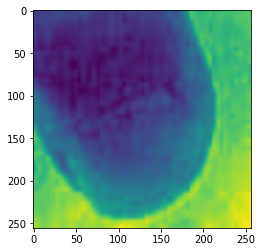

In [135]:
image, label, image_name = next(iter(valid_dataloader))
plt.imshow(image[0][0])

In [150]:
def get_score(pred, label):
    pred = torch.argmax(pred, axis = 1)
    score = 0
    for i in range(len(pred)):
        if pred[i]==label[i]:
            score+=1

    return score
def get_score_with_augment(pred, label, name):
    score = 0
    wrong_name = []
    wrong_label = []
    for i in range(len(pred)):
        if pred[i]==label[i]:
            score+=1
        else:
            wrong_name.append(name[i])
            wrong_label.append(label[i])
    return score, wrong_name, wrong_label

In [137]:
def test_augment(image):
    random_degree = random.randint(0, 8) * 45
    image = tx.rotate(image, random_degree)
    return image


In [141]:
date = "12_24_4"
model.load_state_dict(torch.load("../data/models/"+date+"best.pth"))
model.eval()
total_score = 0
total_pred=[]
total_label=[]
total_name=[]
# one_pred=[]
test_times = 5
with torch.no_grad():
    for j in range(test_times):
        print("epoch : ",j)
        one_pred=[]
        for i, (image, label ,image_name) in enumerate(valid_dataloader):
            image = image.to(device)
            pred = model(image)
            pred = torch.argmax(pred, axis = 1)
            for k in range(pred.shape[0]):
                one_pred.append(pred[k].detach().cpu().numpy())
                if j==0:
                    total_label.append(label[k])
                    total_name.append(image_name[k])
        total_pred.append(one_pred)
#     acc = get_score(pred, label)
#     total_score+=acc
#     pred = torch.argmax(pred, axis = 1)
#     print(pred)
#     print(label)
# print(total_score/len(valid_dataset))



epoch :  0
epoch :  1
epoch :  2
epoch :  3
epoch :  4


In [151]:
total_pred = np.array(total_pred)
last_pred=[]

for j in range(total_pred.shape[1]):
    pred = np.sum(total_pred[:,j])
    if pred>test_times/2:
        pred = 1
    else:
        pred = 0
    last_pred.append(pred)
score, wrong_image, wrong_label = (get_score_with_augment(last_pred,total_label,total_name))
print(score/len(valid_dataset))

0.6716417910447762


In [146]:
len(wrong_image)

22

tensor(0)


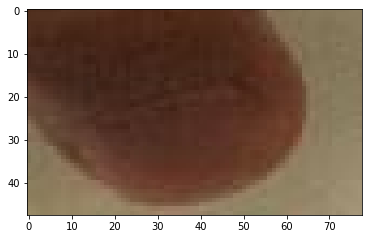

tensor(0)


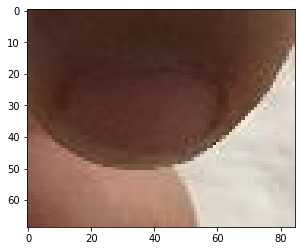

tensor(1)


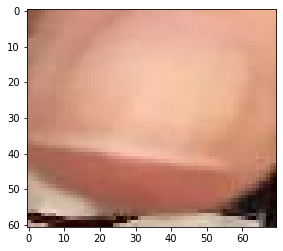

tensor(1)


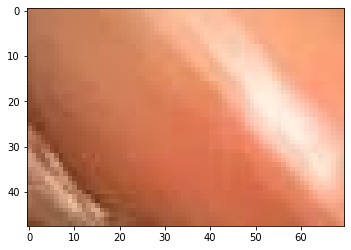

tensor(1)


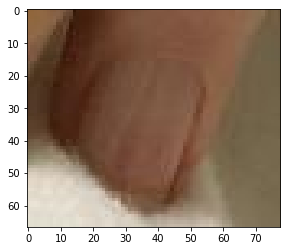

tensor(1)


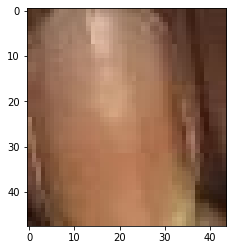

tensor(1)


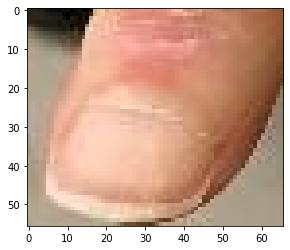

tensor(1)


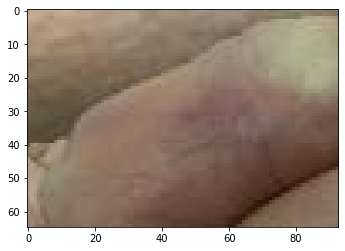

tensor(1)


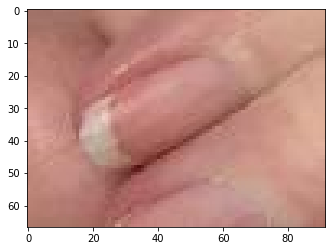

tensor(1)


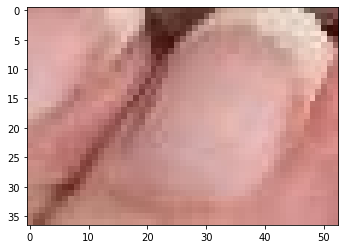

tensor(1)


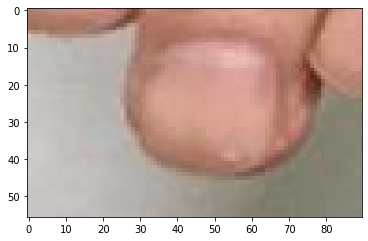

tensor(0)


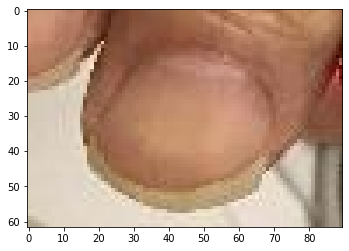

tensor(1)


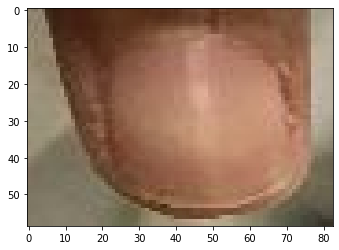

tensor(0)


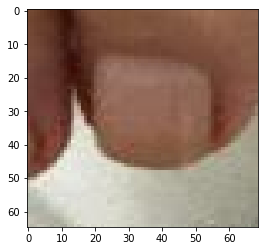

tensor(1)


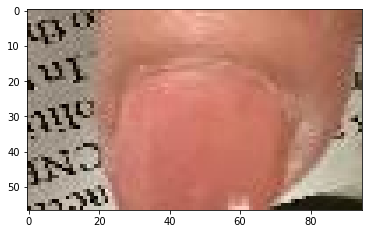

tensor(0)


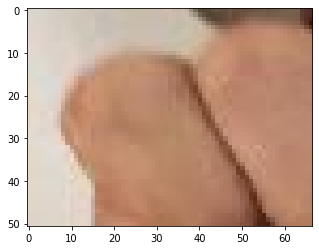

tensor(0)


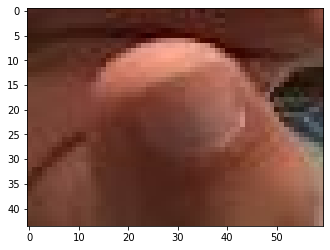

tensor(0)


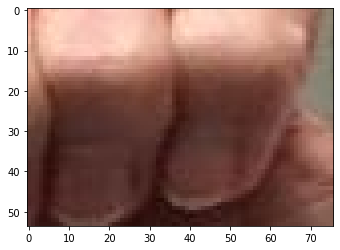

tensor(0)


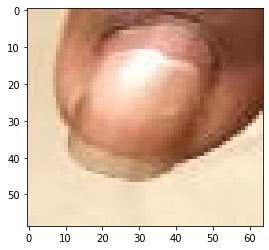

tensor(1)


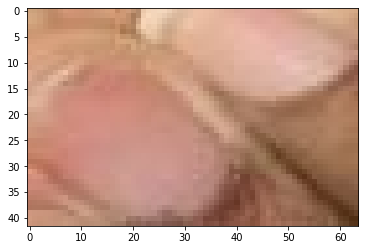

tensor(1)


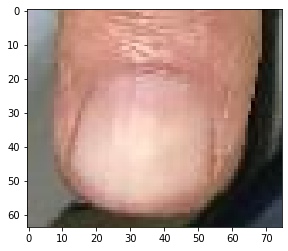

tensor(1)


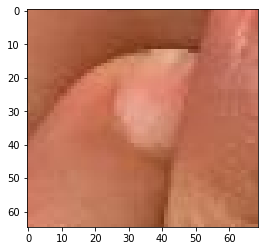

In [152]:
for i in range(len(wrong_image)):
    error_image = cv2.imread("../data/crop_nail_image/"+wrong_image[i])
    error_image = cv2.cvtColor(error_image, cv2.COLOR_BGR2RGB)
    print(wrong_label[i])
    plt.imshow(error_image)
    plt.show()